In [3]:
# ---------- Config ----------
DATA_PATH = "TelecomX_Data (1).json"
OUTDIR    = "salidas_ml"

# ---------- Imports ----------
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pandas import json_normalize
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, RocCurveDisplay, classification_report
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.inspection import permutation_importance
import joblib

os.makedirs(OUTDIR, exist_ok=True)
np.random.seed(42)

In [4]:
# ============================================
# 📌 Extracción
# ============================================
with open(DATA_PATH, "r", encoding="utf-8") as f:
    raw = json.load(f)

# Aplanar JSON anidado con separador "_"
df = json_normalize(raw, sep="_")

print("✅ Datos cargados y aplanados")
print("Shape:", df.shape)

✅ Datos cargados y aplanados
Shape: (7267, 21)


In [7]:
# ============================================
# 🔧 Transformación (preparación para ML)
# ============================================

# 1) Normalizar nombres por si vienen puntos u otros caracteres
df.columns = df.columns.str.replace(r"\s+", "_", regex=True).str.replace(r"[^\w_]", "", regex=True)

# 2) Objetivo (target): mapear Churn Yes/No → 1/0
if "Churn" not in df.columns:
    raise ValueError("No se encuentra la columna 'Churn' en el dataset.")

# Replace empty strings with NaN and drop rows with NaN in 'Churn'
df['Churn'] = df['Churn'].replace('', np.nan)
df.dropna(subset=['Churn'], inplace=True)

y = df["Churn"].map({"Yes": 1, "No": 0})
if y.isna().any(): # This check should now pass after dropping NaNs
    raise ValueError("La columna 'Churn' contiene valores fuera de {'Yes','No'}.")

# 3) Feature engineering: convertir posibles numéricas (tenure y charges)
#    Intentamos convertir cualquier col que parezca numérica
candidate_num = [c for c in df.columns if any(k in c.lower() for k in ["tenure", "monthly", "total", "charges", "seniorcitizen"])]
for c in candidate_num:
    df[c] = pd.to_numeric(df[c], errors="ignore")

# 4) Crear "Cuentas_Diarias" = account_Charges_Monthly/30 si existe
mon_cols = [c for c in df.columns if "charges" in c.lower() and "monthly" in c.lower()]
if mon_cols:
    df["Cuentas_Diarias"] = pd.to_numeric(df[mon_cols[0]], errors="coerce") / 30.0

# 5) Eliminar identificadores directos del set de features
drop_cols = [c for c in df.columns if c.lower() in ["customerid", "churn"]]
X = df.drop(columns=drop_cols)

# 6) Detectar tipos de variables
#    Forzamos numéricas si dtype es número; el resto categóricas (object, bool, category)
numeric_features = [c for c in X.columns if pd.api.types.is_numeric_dtype(X[c])]
categorical_features = [c for c in X.columns if c not in numeric_features]

print(f"🔢 Numéricas: {len(numeric_features)} | 🏷️ Categóricas: {len(categorical_features)}")

# 7) Pipelines de preprocesamiento
numeric_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
categorical_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, numeric_features),
        ("cat", categorical_pipe, categorical_features)
    ],
    remainder="drop"
)

# 8) Train / Test split estratificado
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)

🔢 Numéricas: 4 | 🏷️ Categóricas: 16


/tmp/ipython-input-1339174131.py:24: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[c] = pd.to_numeric(df[c], errors="ignore")


In [21]:
# ============================================
# 🤖 Modelado
# ============================================

models = {
    "LogReg": LogisticRegression(max_iter=1000, class_weight="balanced", n_jobs=None),
    "RandomForest": RandomForestClassifier(
        n_estimators=300, random_state=42, class_weight="balanced", n_jobs=-1
    ),
    "GradientBoosting": GradientBoostingClassifier(random_state=42)
}

results = []
trained = {}

for name, clf in models.items():
    pipe = Pipeline(steps=[("prep", preprocess), ("clf", clf)])
    pipe.fit(X_train, y_train)

    y_pred = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:, 1] if hasattr(pipe.named_steps["clf"], "predict_proba") else None

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    roc = roc_auc_score(y_test, y_proba) if y_proba is not None else np.nan

    results.append([name, acc, prec, rec, f1, roc])
    trained[name] = pipe


In [22]:

# Tabla de resultados
res_df = pd.DataFrame(results, columns=["Modelo", "Accuracy", "Precision", "Recall", "F1", "ROC_AUC"]).sort_values("F1", ascending=False)
print("\n🏁 Resultados en Test:")
print(res_df.to_string(index=False))

# Elegimos el mejor por F1 (puedes cambiar a ROC_AUC si prefieres)
best_name = res_df.iloc[0]["Modelo"]
best_pipe = trained[best_name]
print(f"\n🌟 Mejor modelo: {best_name}")


🏁 Resultados en Test:
          Modelo  Accuracy  Precision   Recall       F1  ROC_AUC
          LogReg  0.766610   0.542683 0.762313 0.634016 0.839232
GradientBoosting  0.793867   0.639037 0.511777 0.568371 0.845171
    RandomForest  0.782510   0.614130 0.483940 0.541317 0.818782

🌟 Mejor modelo: LogReg


In [23]:
# Reporte detallado del mejor
y_pred_best = best_pipe.predict(X_test)
y_proba_best = best_pipe.predict_proba(X_test)[:, 1] if hasattr(best_pipe.named_steps["clf"], "predict_proba") else None

print("\n📋 Classification report (mejor modelo):")
print(classification_report(y_test, y_pred_best, digits=3))


📋 Classification report (mejor modelo):
              precision    recall  f1-score   support

           0      0.900     0.768     0.829      1294
           1      0.543     0.762     0.634       467

    accuracy                          0.767      1761
   macro avg      0.721     0.765     0.731      1761
weighted avg      0.805     0.767     0.777      1761



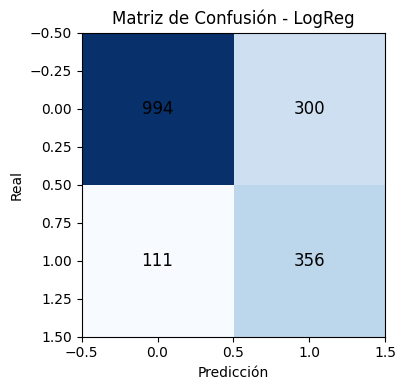

In [26]:
# Matriz de confusión
cm = confusion_matrix(y_test, y_pred_best)
fig, ax = plt.subplots(figsize=(4.5,4))
ax.imshow(cm, cmap="Blues")
ax.set_title(f"Matriz de Confusión - {best_name}")
ax.set_xlabel("Predicción")
ax.set_ylabel("Real")
for (i, j), v in np.ndenumerate(cm):
    ax.text(j, i, str(v), ha="center", va="center", fontsize=12)
plt.tight_layout()
plt.savefig(os.path.join(OUTDIR, f"confusion_{best_name}.png"), dpi=120)



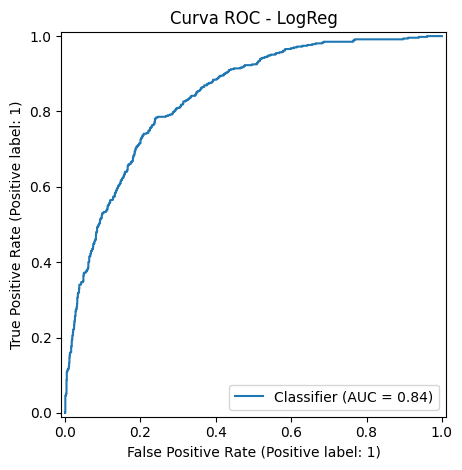

In [28]:
# Curva ROC
if y_proba_best is not None:
    RocCurveDisplay.from_predictions(y_test, y_proba_best)
    plt.title(f"Curva ROC - {best_name}")
    plt.tight_layout()
    plt.savefig(os.path.join(OUTDIR, f"roc_{best_name}.png"), dpi=120)


In [30]:
# ============================================
# 🧠 Importancia de variables (top features)
# ============================================

def get_feature_names(prep: ColumnTransformer):
    """Obtiene nombres de columnas transformadas tras OHE/Scaler."""
    output_names = []
    # Numéricas (no cambian nombre)
    num_names = prep.named_transformers_["num"].get_feature_names_out(numeric_features)
    output_names.extend(num_names)
    # Categóricas (OHE expande)
    cat_names = prep.named_transformers_["cat"].named_steps["ohe"].get_feature_names_out(categorical_features)
    output_names.extend(cat_names)
    return np.array(output_names)

feature_names = get_feature_names(best_pipe.named_steps["prep"])

In [31]:
# Importancias por modelo si están disponibles
importances = None
clf = best_pipe.named_steps["clf"]

if hasattr(clf, "feature_importances_"):
    importances = clf.feature_importances_
    imp_df = pd.DataFrame({"feature": feature_names, "importance": importances}).sort_values("importance", ascending=False).head(20)
elif isinstance(clf, LogisticRegression):
    # Para LR tomamos el |coef|
    coefs = np.abs(clf.coef_[0])
    imp_df = pd.DataFrame({"feature": feature_names, "importance": coefs}).sort_values("importance", ascending=False).head(20)
else:
    # Fallback: Permutation Importance (más lento, pero general)
    print("⌛ Calculando Permutation Importance...")
    r = permutation_importance(best_pipe, X_test, y_test, n_repeats=5, random_state=42, n_jobs=-1)
    imp_df = pd.DataFrame({"feature": feature_names, "importance": r.importances_mean}).sort_values("importance", ascending=False).head(20)

print("\n🔍 Top 20 features más importantes:")
print(imp_df.to_string(index=False))


🔍 Top 20 features más importantes:
                      feature  importance
account_Charges_Total_1052.35    1.696764
 account_Charges_Total_3046.4    1.691406
account_Charges_Total_4820.15    1.607979
 account_Charges_Total_1021.8    1.600929
account_Charges_Total_1327.15    1.599061
account_Charges_Total_6579.05    1.593580
   account_Charges_Total_4481    1.576639
account_Charges_Total_2460.15    1.545430
 account_Charges_Total_3563.8    1.543198
   account_Charges_Total_20.1    1.538424
  account_Charges_Total_740.3    1.529531
account_Charges_Total_4653.85    1.513942
 account_Charges_Total_3147.5    1.504496
   account_Charges_Total_1334    1.471794
account_Charges_Total_6937.95    1.436743
  account_Charges_Total_692.1    1.435878
   account_Charges_Total_20.5    1.420695
 account_Charges_Total_2319.8    1.420220
account_Charges_Total_3160.55    1.418072
 account_Charges_Total_7752.3    1.415249


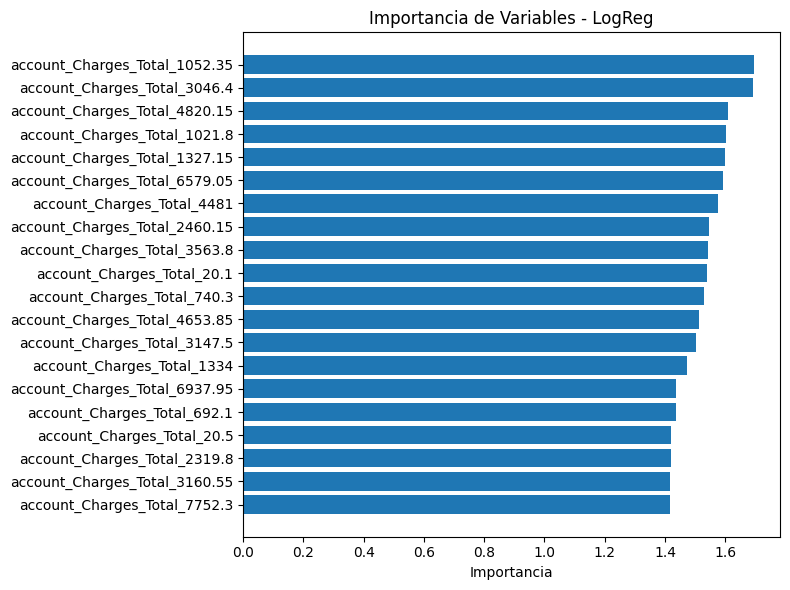

In [32]:
# Guardar gráfico de importancias
plt.figure(figsize=(8,6))
plt.barh(imp_df["feature"][::-1], imp_df["importance"][::-1])
plt.title(f"Importancia de Variables - {best_name}")
plt.xlabel("Importancia")
plt.tight_layout()
plt.savefig(os.path.join(OUTDIR, f"importancias_{best_name}.png"), dpi=140)



In [34]:
# ============================================
# 💾 Guardado de artefactos
# ============================================
joblib.dump(best_pipe.named_steps["prep"], os.path.join(OUTDIR, "preprocesador.joblib"))
joblib.dump(best_pipe, os.path.join(OUTDIR, f"modelo_{best_name}.joblib"))

print(f"\n💾 Artefactos guardados en: {OUTDIR}")
print(f"- preprocesador.joblib")
print(f"- modelo_{best_name}.joblib")
print(f"- confusion_{best_name}.png, roc_{best_name}.png, importancias_{best_name}.png (si aplica)")

# ==========================
# 📄 Conclusión estratégica
# ==========================
print("\n📄 Conclusión (rápida):")
print("- Tenure bajo + contrato mes a mes + cargos altos suelen elevar la probabilidad de churn.")
print("- Servicios de valor (p.ej., TechSupport, OnlineSecurity) suelen correlacionar con menor churn.")
print("- Usa las variables top para diseñar ofertas de retención y alertas tempranas.")



💾 Artefactos guardados en: salidas_ml
- preprocesador.joblib
- modelo_LogReg.joblib
- confusion_LogReg.png, roc_LogReg.png, importancias_LogReg.png (si aplica)

📄 Conclusión (rápida):
- Tenure bajo + contrato mes a mes + cargos altos suelen elevar la probabilidad de churn.
- Servicios de valor (p.ej., TechSupport, OnlineSecurity) suelen correlacionar con menor churn.
- Usa las variables top para diseñar ofertas de retención y alertas tempranas.
